# Intro
In this blog post, we're addressing two aspects of the credit lending decision process. Firstly, we seek to find a score function and a threshold. which help to maximize the total expected profit for a hypothetical bank from their lending decisions. We're exploring various features in the dataset. Secondly, we examine how credit lending affects different groups of prospective borrowers, in the process shedding light on patterns or biases that emerge between the various groups asking for loans from the bank.

# PART A: Grab the Data

In [850]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [851]:
df_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


# PART B: Explore the Data

## Summary Tables:

In [852]:
# Income bins
bins = [0, 50000, 100000, 200000, float('inf')]  

# Labels for bins
labels = ['0-50k', '50k-100k', '100k-200k', '200k+']

# New column in data frame: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
df_train['income_bins'] = pd.cut(df_train['person_income'], bins=bins, labels=labels, right=False)

# Group by the income bins and calculate the mean loan amount for each category
summary_table = df_train.groupby('income_bins', observed=True).agg({'loan_amnt': 'mean', 'cb_person_cred_hist_length': 'mean'}).reset_index()
summary_table.columns = ["Income Bins", "Mean Loan Amnt", "Mean Credit History Length"]

summary_table2 = df_train.groupby('person_home_ownership').agg({'loan_amnt': 'mean', 'loan_int_rate': 'mean', 'cb_person_cred_hist_length': 'mean' }).reset_index()
summary_table2.columns = ["Person Home Ownership", "Mean Loan Amount", "Mean Interest Rate", "Mean Credit History Length"]

In [853]:
summary_table

,Income Bins,Mean Loan Amnt,Mean Credit History Length
0,0-50k,7026.580284,5.551688
1,50k-100k,10464.931791,5.777665
2,100k-200k,13681.890377,6.323887
3,200k+,17331.845238,8.364286


The summary table above demonstrates how a person's income level affects the loan amount a borrower has access to as well as the average length of credit a borrower is offered.

In [854]:
summary_table2

,Person Home Ownership,Mean Loan Amount,Mean Interest Rate,Mean Credit History Length
0,MORTGAGE,10562.137462,10.491245,5.930430
1,OTHER,11235.795455,12.059221,5.465909
2,OWN,8978.912626,10.850169,5.834854
3,RENT,8843.507973,11.448571,5.679575


The summary table above shows how a person's home ownership relates to the amount of money a borrower asks for as well as the interest rate they are offered. 

## Data Visualizations

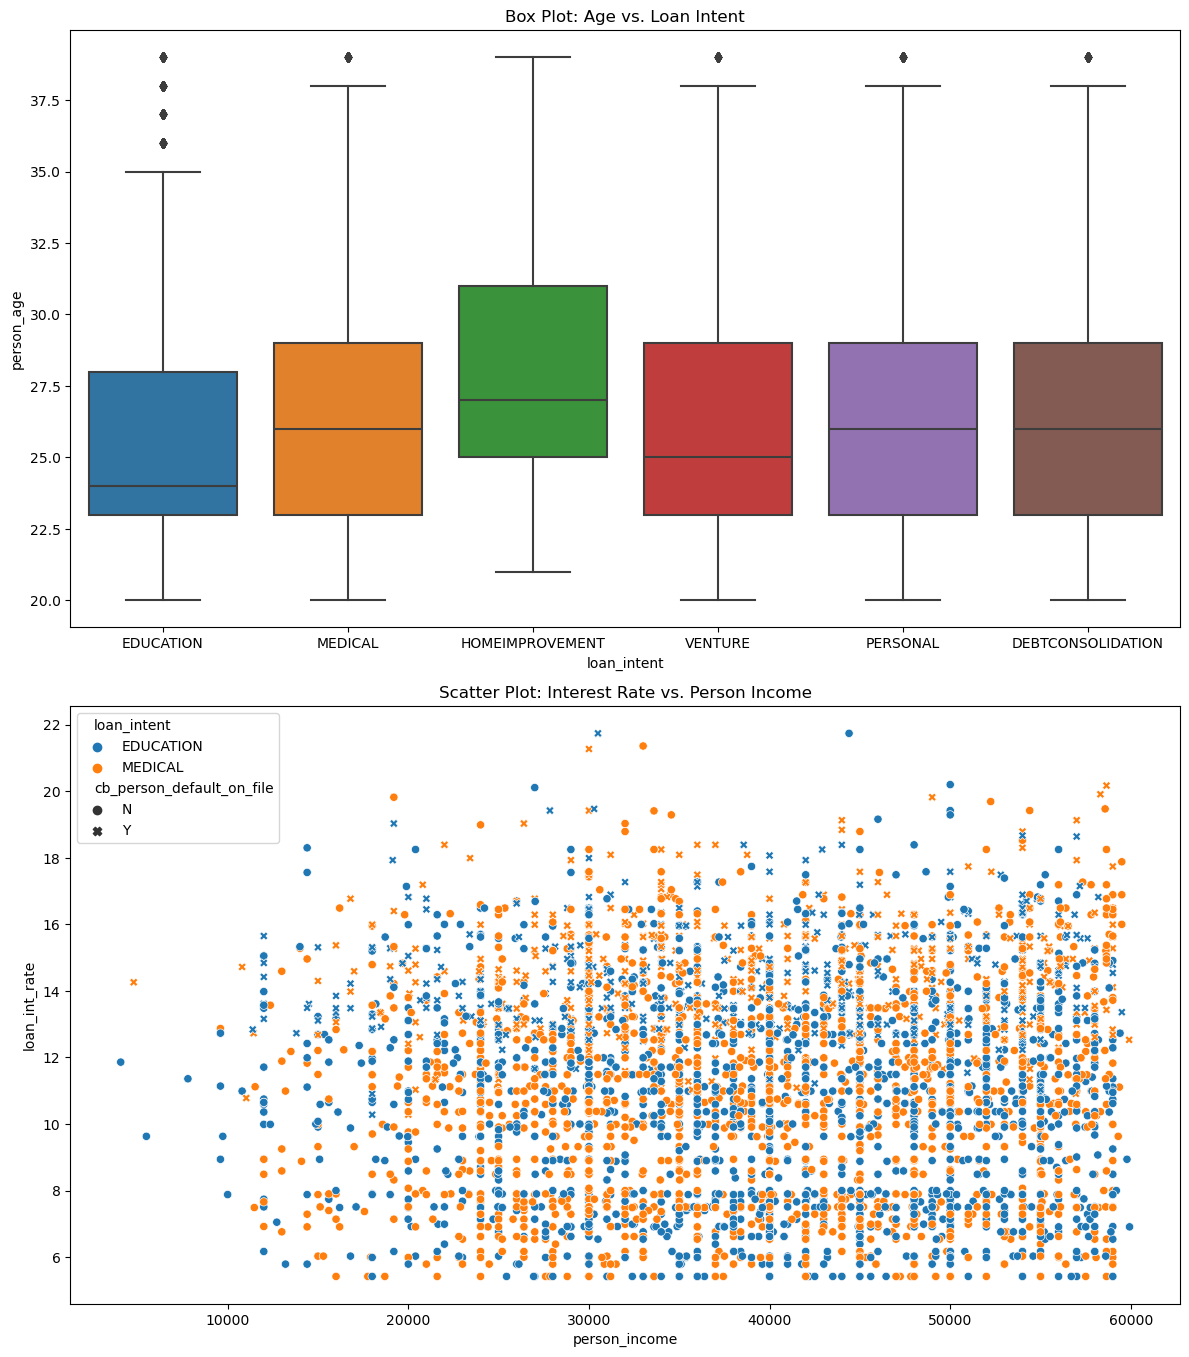

In [855]:
# Graph setup
plt.figure(figsize=(12, 20))

# Modify dataset to remove datapoints with person_age > 90 and person_employment_length > 40
mod_df_train = df_train[df_train['person_age'] < 40]
mod_df_train = mod_df_train[mod_df_train['person_emp_length'] < 40]

plt.subplot(3, 1, 1, title="Box Plot: Age vs. Loan Intent")
sns.boxplot(x= "loan_intent", y= "person_age", data= mod_df_train)

#plt.subplot(3, 1, 2, title="Scatter Plot: Interest Rate vs. Employment Length")
#sns.scatterplot(x= 'person_home_ownership', y= 'person_income', hue= 'cb_person_default_on_file', data= df_train)
#sns.barplot(x= 'person_home_ownership', y= 'person_income', hue= 'cb_person_default_on_file', data= df_train)

#Medical_Education_Venture = ["MEDICAL", "EDUCATION", "VENTURE"]
Medical_Education_Venture = ["MEDICAL", "EDUCATION"]

mod_df_train = mod_df_train[mod_df_train['person_income'] < 60000]
filtered_df = mod_df_train[mod_df_train['loan_intent'].isin(Medical_Education_Venture)]



plt.subplot(3, 1, 2, title="Scatter Plot: Interest Rate vs. Person Income")
#sns.scatterplot(x= 'person_income', y= 'loan_int_rate', hue= 'cb_person_default_on_file', style= 'loan_intent' , data= df_train)
sns.scatterplot(x= 'person_income', y= 'loan_int_rate', style= 'cb_person_default_on_file', hue= 'loan_intent' , data= filtered_df)


plt.tight_layout()
plt.show()

# Part C: Build a Model

In [856]:
# Code comes from: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py
from sklearn.linear_model import LogisticRegression
import numpy as np

In [857]:
# Function borrowed from Palmer's Penguins Blog Post
def prepare_data(df):
  df = df.dropna()
  y = df["loan_status"]
  df = df.drop(["loan_status", "loan_grade"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(df_train)

X_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,income_bins_0-50k,income_bins_50k-100k,income_bins_100k-200k,income_bins_200k+
1,27,98000,3.0,11750,13.47,0.12,6,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,22,36996,5.0,10000,7.51,0.27,4,False,False,False,...,False,False,False,False,True,False,True,False,False,False
3,24,26000,2.0,1325,12.87,0.05,4,False,False,False,...,False,True,False,False,True,False,True,False,False,False
4,29,53004,2.0,15000,9.63,0.28,10,True,False,False,...,True,False,False,False,True,False,False,True,False,False
6,21,21700,2.0,5500,14.91,0.25,2,False,False,False,...,True,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,8.0,3000,7.29,0.02,17,True,False,False,...,False,False,False,False,True,False,False,False,True,False
26060,23,48000,1.0,4325,5.42,0.09,4,False,False,False,...,False,False,False,True,True,False,True,False,False,False
26061,22,60000,0.0,15000,11.71,0.25,4,False,False,False,...,False,True,False,False,True,False,False,True,False,False
26062,30,144000,12.0,35000,12.68,0.24,8,True,False,False,...,False,False,True,False,True,False,False,False,True,False


In [858]:
Features = X_train.columns
LR = LogisticRegression(max_iter = 1000) 
LR.fit(X_train[Features], y_train)
coef = LR.coef_

In [859]:
import numpy as np

total_profits = []

train_probs = LR.predict_proba(X_train[Features])
# This is the probability that the borrower will NOT default
# It's the probability that the value is 0, which means no default
X_train["Default Prob"] = train_probs[:, 0]

# loan_int_rate is a percentage so need to divide by 100
X_train["loan_int_rate"] = X_train["loan_int_rate"] / 100

# Calculate repayment and default profits
X_train["Repay Profit"] = X_train["loan_amnt"] * (1 + 0.25 * X_train["loan_int_rate"])**10 - X_train["loan_amnt"]
X_train["Default Profit"] = X_train["loan_amnt"] * (1 + 0.25 * X_train["loan_int_rate"])**3 - (1.7 * X_train["loan_amnt"])

# Part D: Find a Threshold

In [860]:
def calc_profit(df, y, threshold):
    # Create temporary dataframe to store results
    #temp_df = df.copy()
    temp_df = df
    # Default Unlikely is if the person's probability is greater than the threshold
    temp_df["Default Unlikely"] = (temp_df["Default Prob"] > threshold).astype(int)
    # Correct Assumption is if the bank gives them a loan and they don't default
    temp_df["Correct Assumption"] = (temp_df["Default Unlikely"] == y).astype(int)
    # ASK ABOUT THIS
    temp_df["Total Profit"] = temp_df["Correct Assumption"] * temp_df["Repay Profit"] - (1 - temp_df["Correct Assumption"]) * temp_df["Default Profit"]
    # Return total profit for this threshold
    return temp_df["Total Profit"].sum()

# Iterating through threshold values
thresholds = np.linspace(0, 1, 100)

max_profit = 0
#max_profit = float('-inf')

optimal_threshold = 0

for threshold in thresholds:
    total_profit = calc_profit(X_train, y_train, threshold)
    total_profits.append(total_profit)
    # Update max_profit and optimal_threshold if total_profit is higher
    if total_profit > max_profit:
        max_profit = total_profit
        optimal_threshold = threshold


print("Optimal Threshold:", optimal_threshold)
print("Max Profit:", max_profit)
print("Profit per Person: ", max_profit / len(X_train))

Optimal Threshold: 0.5656565656565657
Max Profit: 126739142.43103035
Profit per Person:  5532.769128695611


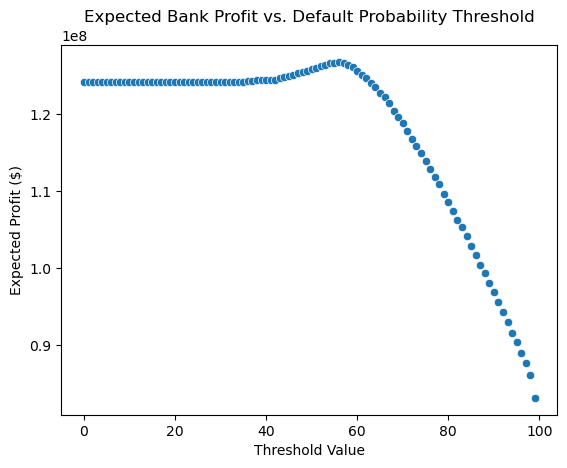

In [861]:
sns.scatterplot(data=total_profits)
plt.xlabel("Threshold Value")
plt.ylabel("Expected Profit ($)")
plt.title("Expected Bank Profit vs. Default Probability Threshold")
plt.show()

Here we can visualize the maximum profit generated given a threshold value between 0 and 100. The global maximum for expected profit comes when the threshold for risking loans to borrowers is around 0.56.

# Part E: Evaluate your Model from the Bank's Perspective

In [862]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

Prepare the test data and linear regression model, same as before with the training data. 

In [863]:
X_test, y_test = prepare_data(df_test)
TestFeatures = X_test.columns
LRE = LogisticRegression(max_iter = 1000) 
LRE.fit(X_test[TestFeatures], y_test)

LogisticRegression(max_iter=1000)

In [864]:
test_probs = LRE.predict_proba(X_test[TestFeatures])
X_test["Default Prob"] = test_probs[:, 0]

# loan_int_rate is a percentage so need to divide by 100
X_test["loan_int_rate"] = X_test["loan_int_rate"] / 100

# Calculate repayment and default profits
X_test["Repay Profit"] = X_test["loan_amnt"] * (1 + 0.25 * X_test["loan_int_rate"])**10 - X_test["loan_amnt"]
X_test["Default Profit"] = X_test["loan_amnt"] * (1 + 0.25 * X_test["loan_int_rate"])**3 - 1.7 * X_test["loan_amnt"]

test_total_profits = []

In [865]:

# Iterating through threshold values
#test_thresholds = np.linspace(0, 1, 100)

#test_max_profit = 0
#max_profit = float('-inf')

#test_optimal_threshold = 0

#for test_threshold in test_thresholds:
#    test_total_profit = calc_profit(X_test, y_test, test_threshold)
#    total_profits.append(total_profit)
#    # Update max_profit and optimal_threshold if total_profit is higher
#    if total_profit > max_profit:
#        max_profit = total_profit
#        optimal_threshold = threshold


#print("Optimal Threshold:", optimal_threshold)
#print("Max Profit:", max_profit)
#print("Profit per Person: ", max_profit / len(X_train))

Use the calc_profit function with the threshold (0.5656) from earlier that resulted in the highest expected profit. 

In [866]:
test_threshold = optimal_threshold
total_test_profit = calc_profit(X_test, y_test, test_threshold)
print(f"Expected profit with test data: {total_test_profit:.2f}")
print("Profit per Person: ", total_test_profit / len(X_test))

Expected profit with test data: 31972199.40
Profit per Person:  5578.816856325797


Let's see where ths expected profit using the testing data measures up on our graph of expected profits from the training data. 

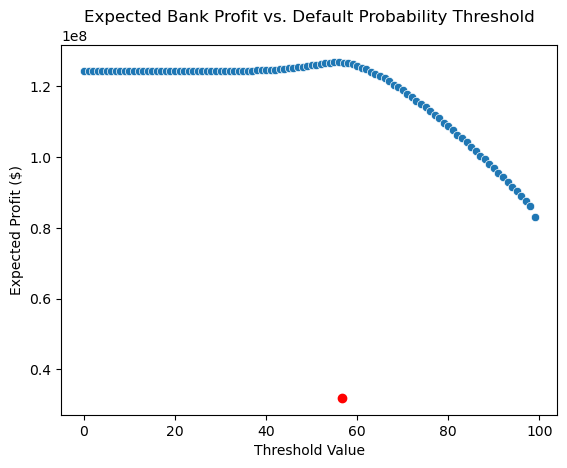

In [867]:
# Scale the test_threshold data point accordingly
test_threshold = test_threshold * 100

sns.scatterplot(data=total_profits)
plt.scatter(y=total_test_profit, x=test_threshold, color="red")
plt.xlabel("Threshold Value")
plt.ylabel("Expected Profit ($)")
plt.title("Expected Bank Profit vs. Default Probability Threshold")
plt.show()

The red dot is the demonstrates the significant negative difference in expected profit between the testing and training data at that optimal training threshold.  

In [868]:
X_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,Default Prob,Repay Profit,Default Profit,Default Unlikely,Correct Assumption,Total Profit
0,21,42000,5.0,1000,0.1558,0.02,4,False,False,False,...,False,True,True,False,0.829020,465.367227,-578.539601,1,1,465.367227
1,32,51000,2.0,15000,0.1136,0.29,9,True,False,False,...,False,False,True,False,0.603650,4847.780062,-9185.361205,1,0,9185.361205
2,35,54084,2.0,3000,0.1261,0.06,6,False,False,False,...,False,False,True,False,0.863782,1091.841800,-1807.236578,1,0,1807.236578
3,28,66300,11.0,12000,0.1411,0.15,6,True,False,False,...,False,False,True,False,0.795915,4972.214553,-7084.777554,1,1,4972.214553
4,22,70550,0.0,7000,0.1588,0.08,3,False,False,False,...,False,False,True,False,0.888388,3331.859215,-4032.764115,1,1,3331.859215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,29,78000,2.0,18000,0.0662,0.23,5,True,False,False,...,True,False,True,False,0.764900,3210.941787,-11691.427669,1,0,11691.427669
6513,27,44640,0.0,12800,0.1183,0.29,9,False,False,False,...,False,False,True,False,0.599646,4331.281644,-7790.401145,1,0,7790.401145
6514,24,48000,5.0,10400,0.0737,0.22,3,False,False,True,...,False,True,True,False,0.689860,2083.140437,-6694.483153,1,0,6694.483153
6515,26,65000,6.0,6000,0.0907,0.09,3,True,False,False,...,False,False,True,False,0.876529,1508.058449,-3782.525248,1,0,3782.525248


# Part F: Evaluate your Model from the Borrower's Perspective

## Is it more difficult for people in certain age groups to access credit under your proposed system?

Similar to the summary table used earlier in the post, we can create age brackets to see what age groups the banks feel confident in, as indicated by the model and the repay/default probability that is compared with the threshold. 

In [872]:
# Income bins
bins = [0, 20, 30, 40, 50, 60, 70, 80, float('inf')]  

# Labels for bins
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

# New column in data frame: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
X_test['age_bins'] = pd.cut(X_test['person_age'], bins=bins, labels=labels, right=False)

# Group by the income bins and calculate the mean loan amount for each category
summary_table3 = X_test.groupby('age_bins', observed=True).agg({'Default Unlikely': 'mean', 'Correct Assumption': 'mean'}).reset_index()
summary_table3.columns = ["Age Bins", "Avg Prob of Repay (at Training Optimal Threshold)", "Avg Bank Assumption"]

summary_table3

,Age Bins,Avg Prob of Repay (at Training Optimal Threshold),Avg Bank Assumption
0,20-30,0.868872,0.175803
1,30-40,0.890895,0.165620
2,40-50,0.903846,0.150000
3,50-60,0.904762,0.166667
4,60-70,0.750000,0.250000
5,70-80,1.000000,0.500000


## Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group?

## What about people seeking loans for business ventures or education? How does a person’s income level impact the ease with which they can access credit under your decision system?

# Part G: Write and Reflect